## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
# load in data
data = pd.read_csv('data/final_working_data.csv')

In [3]:
# dropping columns with correlation coefficient greater than 0.7
# see nd_project_3 notebook for more details
data_uncorr = data.drop(columns=['round_H', 'time_first_to_last_funding'], 

#renaming full dataset
data_full = data

## X/Y Split

In [804]:
len(data[data['status']=='closed'])

1893

In [ ]:
# choosing the dataset I want to work with
data = data_uncorr

Splitting out X and Y for train-test split:

In [805]:
# removinglen(da irrelevant columns w/ obvious correlations, lack of insight
X = data.drop(columns=['status', 'name', 'country_code', 'state_code', 
                       'city'], 
              axis=1)

# need to drop these rows if I go with binary version
#'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G'
#'undisclosed', 'angel' ,'grant', 'venture', 'equity_crowdfunding', 
# 'convertible_note', 'seed', 'private_equity', 'product_crowdfunding'

encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(data['status'])) 
# acquired is 0, closed is 1, operating is 2

# binary where 0 is acquired/operating(success), 1 is closed
y_bin = pd.Series([1 if val==1 else 0 for val in y])

In [806]:
print(y.value_counts(normalize=True))
y_bin.value_counts(normalize=True)

2    0.874589
0    0.069800
1    0.055611
dtype: float64


0    0.944389
1    0.055611
dtype: float64

In [748]:
X.dtypes

market                    object
region                    object
funding_rounds           float64
founded_month              int64
founded_year               int64
seed                     float64
venture                  float64
equity_crowdfunding      float64
undisclosed              float64
convertible_note         float64
debt_financing           float64
angel                    float64
grant                    float64
private_equity           float64
product_crowdfunding     float64
round_A                  float64
round_B                  float64
round_C                  float64
round_D                  float64
round_E                  float64
round_F                  float64
round_G                  float64
international              int64
time_to_first_funding    float64
dtype: object

In [807]:
# Transforming founded_year to float for one hot encoding
X['founded_year'] = [float(x) for x in X['founded_year']]
X['founded_month'] = [float(x) for x in X['founded_month']]
X.dtypes

market                    object
funding_total_usd        float64
region                    object
funding_rounds           float64
founded_month            float64
founded_year             float64
seed                     float64
venture                  float64
equity_crowdfunding      float64
undisclosed              float64
convertible_note         float64
debt_financing           float64
angel                    float64
grant                    float64
private_equity           float64
product_crowdfunding     float64
round_A                  float64
round_B                  float64
round_C                  float64
round_D                  float64
round_E                  float64
round_F                  float64
round_G                  float64
international              int64
time_to_first_funding    float64
dtype: object

### Feature Reduction - Market, Region

In [808]:
sum(X['market'].value_counts() >= 100)

50

In [809]:
X['market'][X['market'].map(X['market'].value_counts()) < 100] = 'other'
X['market'].value_counts()

other                   10318
Software                 3138
Biotechnology            2014
Mobile                   1465
E-Commerce               1308
Curated Web              1257
Enterprise Software       911
Games                     832
Advertising               804
Health Care               742
Social Media              702
Hardware + Software       685
Clean Technology          660
Education                 596
Finance                   592
Health and Wellness       555
Analytics                 482
Manufacturing             408
Security                  348
Hospitality               330
Real Estate               318
Consulting                305
Fashion                   301
Semiconductors            294
Travel                    277
News                      276
Web Hosting               251
SaaS                      227
Search                    220
Messaging                 212
Music                     211
Sports                    209
Internet                  199
Medical   

In [811]:
sum(X['region'].value_counts() > 450) # top 10 regions

11

In [812]:
X['region'][X['region'].map(X['region'].value_counts()) <= 420] = 'other'
# combine na and low dens for 'other' category
X['region'].value_counts()

other               19618
SF Bay Area          5289
New York City        2089
Boston               1267
London               1202
Los Angeles          1050
Seattle               687
Washington, D.C.      532
Chicago               526
Denver                462
Austin                460
San Diego             435
Tel Aviv              423
Name: region, dtype: int64

## Train Test Split - Function

In [1]:
def train_test_preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]
    
    # Categorizing features in preparation for scaling / encoding
    X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
    X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

    X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

    cat_columns = ['market', 'region']
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Min Max Scaler:
    scaler = MinMaxScaler() # instantiate MinMaxScaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [2]:
X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y)

NameError: name 'X' is not defined

In [ ]:
print(f"X_train is a DataFrame with {X_train.shape[0]} rows and \
      {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

print("There are {} features in train set".format(len(X_train_processed.columns)))
print("There are {} features in test set".format(len(X_test_processed.columns)))

print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))

print("target breakdown: ", y_train.value_counts(normalize=True))

display(X_train_processed.head())
display(X_train_scaled.head())

In [937]:
# correlation check
df_corr=X_train_processed.corr()

df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']
df.drop_duplicates(inplace=True)

df[(df.cc>.5) & (df.cc<1)]

,cc
pairs,
"(round_E, round_F)",0.734840
"(round_F, debt_financing)",0.721803
"(venture, round_B)",0.710362
"(venture, round_C)",0.672736
"(founded_year, time_to_first_funding)",0.640687
"(round_E, debt_financing)",0.598267
"(international, region_other)",0.578850
"(round_D, venture)",0.542664
"(round_A, round_B)",0.541239


## Baseline Model

In [2]:
X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y)

NameError: name 'X' is not defined

Logistic regression:

In [902]:
baseline_model = LogisticRegression(random_state=42, class_weight='balanced')
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [903]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

In [904]:
print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85     24123
           1       0.15      0.76      0.26      1407

    accuracy                           0.76     25530
   macro avg       0.57      0.76      0.56     25530
weighted avg       0.94      0.76      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      8024
           1       0.15      0.73      0.25       486

    accuracy                           0.75      8510
   macro avg       0.56      0.74      0.55      8510
weighted avg       0.93      0.75      0.81      8510



In [826]:
coef_df = pd.DataFrame(baseline_model.coef_, columns=X_train_scaled.columns)
coef_df.to_csv('coef_logreg_base.csv')

#### Function to Print Scores

In [81]:
def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('PR AUC: ', average_precision_score(y_test, y_hat_test))
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

In [907]:
print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.255827854154214
Testing F1:  0.24938531787846854


PR AUC:  0.12522453109693021


Training Accuracy:  0.7561692126909518
Testing Accuracy:  0.7488836662749706


#### Function to Return Scores - Binary

In [82]:
def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

## Other Models

### Logistic Regression

In [ ]:
# Grid search on baseline for hyperparameter tuning

In [769]:
param_grid = {'penalty':['l1', 'l2', None],
              'solver':['lbfgs', 'newton-cg', 'sag'],
              'C': [1.0, 1e12],
             }

In [770]:
# 3min runtime
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='average_precision') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [1.0, 1000000000000.0],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag']},
             scoring='average_precision')

In [771]:
grid_logreg.best_params_ # recall, f1 same params

{'C': 1000000000000.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [772]:
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)
print(classification_report(y_test, y_preds_grid_lr))
average_precision_score(y_test, y_preds_grid_lr)

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      7552
           1       0.15      0.73      0.25       446

    accuracy                           0.75      7998
   macro avg       0.56      0.74      0.55      7998
weighted avg       0.93      0.75      0.82      7998



0.1246618252661721

In [908]:
# best logreg
logreg_best = LogisticRegression(random_state=42, class_weight='balanced', 
                                 C=1e12,  penalty='l2')
logreg_best.fit(X_train_scaled, y_train)

y_hat_train_2 = logreg_best.predict(X_train_scaled)
y_hat_test_2 = logreg_best.predict(X_test_scaled)

print_scores(y_train, y_hat_train_2, y_test, y_hat_test_2)
print(classification_report(y_test, y_hat_test_2))

Training Recall:  0.7746979388770433
Testing Recall:  0.7407407407407407


Training F1:  0.2587537091988131
Testing F1:  0.2527202527202527


PR AUC:  0.1276570062122694


Training Accuracy:  0.7553858206032119
Testing Accuracy:  0.7498237367802585
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     24123
           1       0.16      0.77      0.26      1407

    accuracy                           0.76     25530
   macro avg       0.57      0.76      0.56     25530
weighted avg       0.94      0.76      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      8024
           1       0.15      0.74      0.25       486

    accuracy                           0.75      8510
   macro avg       0.57      0.75      0.55      8510
weighted avg       0.93      0.75      0.82      8510



In [775]:
coef_df = pd.DataFrame(logreg_best.coef_, columns=X_train_scaled.columns)
coef_df.to_csv('coef_logreg_best.csv')

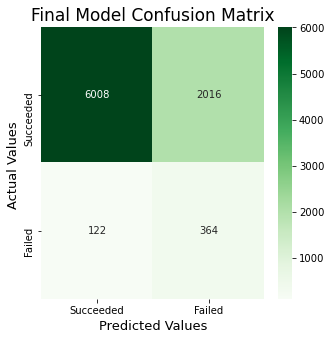

In [830]:
# visualizing predictions
conf_matrix = confusion_matrix(y_test, y_hat_test_2)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Logistic Regression Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Random Forest

In [831]:
rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                             min_samples_leaf=10, max_depth=5,
                             class_weight='balanced')

rfc.fit(X_train_processed, y_train)

y_hat_train_3 = rfc.predict(X_train_processed)
y_hat_test_3 = rfc.predict(X_test_processed)

print_scores(y_train, y_hat_train_3, y_test, y_hat_test_3)

Training Recall:  0.7107320540156361
Testing Recall:  0.6790123456790124


Training F1:  0.2389486260454002
Testing F1:  0.2335456475583864


PR AUC:  0.11408952616682085


Training Accuracy:  0.7504896200548374
Testing Accuracy:  0.745475910693302


In [108]:
# Tuning the model with grid search
param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[3,8,12],
              'min_samples_leaf': [5,10],
              'class_weight': [None, 'balanced']
             }

In [110]:
## long run time

grid_rfc = GridSearchCV(rfc, param_grid, cv = 5, scoring='recall') 
# macro or weighted?
grid_rfc.fit(X_train_processed, y_train) #17 min execution

KeyboardInterrupt: 

In [119]:
grid_rfc.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 5}

In [120]:
y_preds_grid_rfc = grid_rfc.predict(X_test)

In [121]:
display(confusion_matrix(y_test, y_preds_grid_rfc))
print(classification_report(y_test, y_preds_grid_rfc))

array([[    0,     0,   923],
       [    0,     0,   678],
       [    0,     0, 10430]])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       923
           1       0.00      0.00      0.00       678
           2       0.87      1.00      0.93     10430

    accuracy                           0.87     12031
   macro avg       0.29      0.33      0.31     12031
weighted avg       0.75      0.87      0.81     12031



In [ ]:
# visualizing predictions
conf_matrix = confusion_matrix(y_test, y_preds_grid_rfc)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

# Title & Axis Labels
ax.set_title('Best RFC Model Confusion Matrix', fontsize=17);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Set tick labels
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Feature Importance

In [342]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_df = pd.DataFrame(feats.items())

In [343]:
feats_df.columns = ['col', 'feat_importance']
feats_df = feats_df.sort_values(by=['feat_importance'], ascending=False)
feats_df_20 = feats_df[:20]
feats_df_30 = feats_df[:30]

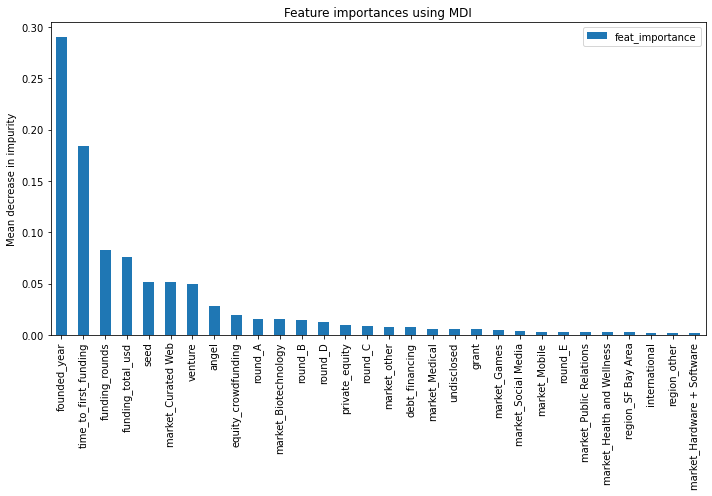

In [344]:
fig, ax = plt.subplots(figsize = (10,7))
feats_df_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_df_30['col'])
fig.tight_layout()

### Tree Models


#### Decision Tree Classifier**

This model seems to be the best compromise, with recall at around 80% and accuracy at 70% / PR AUC at 12%

In [909]:
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                             min_samples_leaf=5, max_depth=10)
dtc.fit(X_train_processed, y_train)

y_hat_train_dtc = dtc.predict(X_train_processed)
y_hat_test_dtc = dtc.predict(X_test_processed)

print_scores(y_train, y_hat_train_dtc, y_test, y_hat_test_dtc)
print(classification_report(y_train, y_hat_train_dtc))
print(classification_report(y_test, y_hat_test_dtc))

Training Recall:  0.9303482587064676
Testing Recall:  0.7592592592592593


Training F1:  0.289505695012717
Testing F1:  0.24062601891098792


PR AUC:  0.12229818889522745


Training Accuracy:  0.7483352918135526
Testing Accuracy:  0.7263219741480611
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     24123
           1       0.17      0.93      0.29      1407

    accuracy                           0.75     25530
   macro avg       0.58      0.83      0.57     25530
weighted avg       0.95      0.75      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      8024
           1       0.14      0.76      0.24       486

    accuracy                           0.73      8510
   macro avg       0.56      0.74      0.54      8510
weighted avg       0.93      0.73      0.80      8510



In [371]:
# Grid search
param_grid = {'criterion':['gini','entropy'],
              'max_depth':[None,3,8,12],
              'min_samples_leaf': [1,5,10,15],
              'class_weight': [None, 'balanced']
             }

grid_dtc = GridSearchCV(dtc, param_grid, cv = 5, scoring='recall') 
grid_dtc.fit(X_train_processed, y_train)
y_preds_grid_train_dtc = grid_dtc.predict(X_train_processed)
y_preds_grid_dtc = grid_dtc.predict(X_test_processed)

print(classification_report(y_test, y_preds_grid_dtc))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      8024
           1       0.13      0.80      0.22       486

    accuracy                           0.68      8510
   macro avg       0.56      0.74      0.51      8510
weighted avg       0.93      0.68      0.77      8510



In [373]:
grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 15}

In [910]:
dtc_best = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  min_samples_leaf=15, max_depth=8, 
                                  criterion='entropy')
dtc_best.fit(X_train_processed, y_train)

y_hat_train_dtc_best = dtc_best.predict(X_train_processed)
y_hat_test_dtc_best = dtc_best.predict(X_test_processed)

print_scores(y_train, y_hat_train_dtc_best, y_test, y_hat_test_dtc_best)
print(classification_report(y_train, y_hat_train_dtc_best))
print(classification_report(y_test, y_hat_test_dtc_best))

Training Recall:  0.8770433546552949
Testing Recall:  0.8024691358024691


Training F1:  0.25117036433950746
Testing F1:  0.2333931777378815


PR AUC:  0.1208617154482457


Training Accuracy:  0.7117900509204858
Testing Accuracy:  0.6989424206815511
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     24123
           1       0.15      0.88      0.25      1407

    accuracy                           0.71     25530
   macro avg       0.57      0.79      0.54     25530
weighted avg       0.94      0.71      0.79     25530

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      8024
           1       0.14      0.80      0.23       486

    accuracy                           0.70      8510
   macro avg       0.56      0.75      0.52      8510
weighted avg       0.93      0.70      0.78      8510



#### ExtraTrees

In [834]:
from sklearn.ensemble import ExtraTreesClassifier

ext = ExtraTreesClassifier(random_state=42, class_weight='balanced', 
                           criterion='entropy')#, min_samples_leaf=10, 
                           #max_depth=5)
ext.fit(X_train_processed, y_train)

y_hat_train_ext = ext.predict(X_train_processed)
y_hat_test_ext = ext.predict(X_test_processed)

print(classification_report(y_train, y_hat_train_ext))
print(classification_report(y_test, y_hat_test_ext))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24123
           1       0.99      1.00      1.00      1407

    accuracy                           1.00     25530
   macro avg       1.00      1.00      1.00     25530
weighted avg       1.00      1.00      1.00     25530

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8024
           1       0.14      0.03      0.04       486

    accuracy                           0.93      8510
   macro avg       0.54      0.51      0.51      8510
weighted avg       0.90      0.93      0.91      8510



In [462]:
param_grid = {#'criterion':['gini','entropy','log_loss'],
              'max_depth':[12,20,50],
              'min_samples_leaf': [30,50,100],
              #'class_weight': [None, 'balanced'],
              'max_features': ['auto']
             }

In [300]:
ext = ExtraTreesClassifier(random_state=42)
ext.fit(X_train_processed, y_train)

ExtraTreesClassifier(random_state=42)

In [463]:
grid_ext = GridSearchCV(ext, param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)
y_hat_train_gext = grid_ext.predict(X_train_processed)
y_hat_test_gext = grid_ext.predict(X_test_processed)

In [459]:
grid_ext.best_estimator_

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', max_depth=12,
                     min_samples_leaf=30, random_state=42)

In [464]:
grid_ext.best_params_

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 50}

In [ ]:
grid_ext.feature_im

In [465]:
print_scores(y_train, y_hat_train_gext, y_test, y_hat_test_gext)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.23268457105577905
Testing F1:  0.2248258391386954


ROC AUC Score:  0.7208469755343023


Training Accuracy:  0.7235801018409714
Testing Accuracy:  0.7123384253819036


In [835]:
ext_best = ExtraTreesClassifier(class_weight='balanced', criterion='entropy', 
                                max_depth=50, min_samples_leaf=50, 
                                random_state=42, max_features='auto')
ext_best.fit(X_train_processed, y_train)

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', max_depth=50,
                     min_samples_leaf=50, random_state=42)

In [836]:
y_pred_gext_train = ext_best.predict(X_train_processed)
y_pred_gext_test = ext_best.predict(X_test_processed)
print_scores(y_train, y_hat_train_gext, y_test, y_hat_test_gext)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.23268457105577905
Testing F1:  0.2248258391386954


PR AUC:  0.112441072034747


Training Accuracy:  0.7235801018409714
Testing Accuracy:  0.7123384253819036


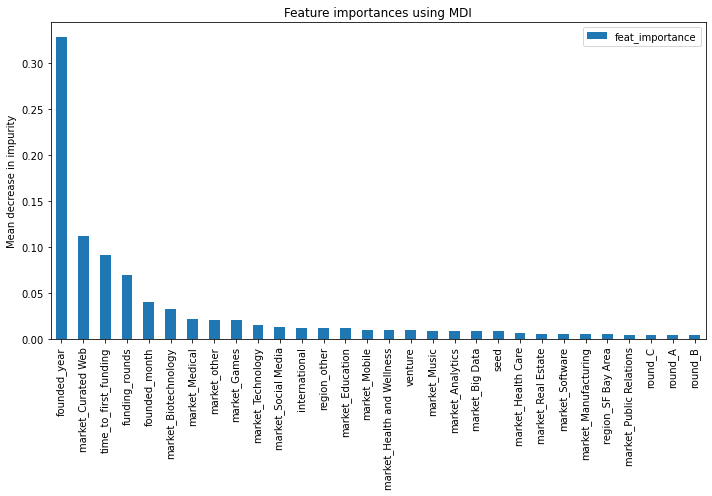

In [837]:
## Feature Selection

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, ext_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_df = pd.DataFrame(feats.items())

feats_df.columns = ['col', 'feat_importance']
feats_df = feats_df.sort_values(by=['feat_importance'], ascending=False)
feats_df_20 = feats_df[:20]
feats_df_30 = feats_df[:30]

fig, ax = plt.subplots(figsize = (10,7))
feats_df_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_df_30['col'])
fig.tight_layout()

### Gradient Boosted Models

#### XGBoost**

This model has best recall, but seems that is the case because we are casting a wide net. Accuracy and precision are sacrificed for the sake of boosting recall.

In [912]:
clf = XGBClassifier(random_state=42, max_depth=4, scale_pos_weight=50, 
                    min_child_weight=3, learning_rate=0.1, subsample= 0.7)
clf.fit(X_train_processed, y_train)

y_hat_train_clf = clf.predict(X_train_processed)
y_hat_test_clf = clf.predict(X_test_processed)

print(classification_report(y_train, y_hat_train_clf))
print(classification_report(y_test, y_hat_test_clf))
print_scores(y_train, y_hat_train_clf, y_test, y_hat_test_clf)

              precision    recall  f1-score   support

           0       1.00      0.60      0.75     24123
           1       0.13      0.98      0.22      1407

    accuracy                           0.62     25530
   macro avg       0.56      0.79      0.49     25530
weighted avg       0.95      0.62      0.72     25530

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      8024
           1       0.12      0.93      0.21       486

    accuracy                           0.61      8510
   macro avg       0.56      0.76      0.48      8510
weighted avg       0.94      0.61      0.71      8510

Training Recall:  0.9815209665955935
Testing Recall:  0.9300411522633745


Training F1:  0.22313782517369526
Testing F1:  0.21275594257472344


PR AUC:  0.11570898575511247


Training Accuracy:  0.6233450842146494
Testing Accuracy:  0.6069330199764983


Grid search for hyperparameter tuning

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_processed, y_train)

In [700]:
# setting up grid search
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[20,50,100]
}

In [ ]:
# Hypertuning parameters with Grid Search

In [701]:
grid_xgb = GridSearchCV(xgb, param_grid, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

In [702]:
y_hat_train_xgb = grid_xgb.predict(X_train_processed)
y_hat_test_xgb = grid_xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train_xgb, y_test, y_hat_test_xgb)

Training Recall:  0.8933901918976546
Testing Recall:  0.8148148148148148


Training F1:  0.27797434763379036
Testing F1:  0.2549903412749517


PR AUC:  0.1337310094694761


Training Accuracy:  0.7442224833529182
Testing Accuracy:  0.7280846063454759


In [704]:
grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'scale_pos_weight': 20,
 'subsample': 0.7}

In [911]:
# Storing best performing model from grid search
# xgb_best = XGBClassifier(random_state=42, learning_rate=0.1, 
#                          max_depth= 4, min_child_weight= 7,
#                          scale_pos_weight= 100, subsample= 0.5)

xgb_best = XGBClassifier(random_state=42, learning_rate=0.1, 
                         max_depth= 4, min_child_weight= 3,
                         scale_pos_weight= 20, subsample= 0.7)

xgb_best.fit(X_train_processed, y_train)

y_hat_train_xgb_best = xgb_best.predict(X_train_processed)
y_hat_test_xgb_best = xgb_best.predict(X_test_processed)

print_scores(y_train, y_hat_train_xgb_best, y_test, y_hat_test_xgb_best)

Training Recall:  0.8862828713574982
Testing Recall:  0.8271604938271605


Training F1:  0.2755496630206607
Testing F1:  0.2581059390048154


PR AUC:  0.1363517287111975


Training Accuracy:  0.7431649040344692
Testing Accuracy:  0.7284371327849589


In [ ]:
# Feature importance using best model

In [841]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)[:20]

[('founded_year', 215.02996173380004),
 ('funding_rounds', 211.90692118380005),
 ('time_to_first_funding', 149.1557620872671),
 ('market_Curated Web', 94.98529302222222),
 ('funding_total_usd', 85.35961955777476),
 ('international', 65.95872238333334),
 ('market_Enterprise Software', 64.97660825),
 ('round_C', 64.93544948),
 ('market_Advertising', 63.1362457),
 ('undisclosed', 63.124936116666674),
 ('market_Hardware + Software', 62.17092422500001),
 ('debt_financing', 59.25259103833336),
 ('market_Biotechnology', 58.582680679999996),
 ('market_Video', 57.4144745),
 ('round_D', 56.64323220000001),
 ('market_Analytics', 56.367070379999994),
 ('venture', 55.99698201000001),
 ('region_Denver', 55.9817276),
 ('market_Mobile', 55.62001216666666),
 ('market_other', 53.560516361)]

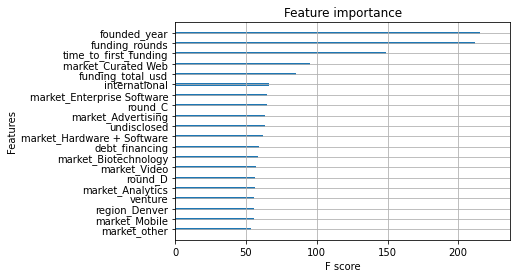

In [842]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

## Feature Selection

In [ ]:
### In general, market seems to generate greater feature importance than region.
### Thus willing to do top 5 or 10 regions rather than top 40 and see if that
### reduces overfitting

In [162]:
from sklearn.feature_selection import SelectKBest, chi2

X_5_best= SelectKBest(chi2, k=20).fit(X_train_scaled, y_train)
mask = X_5_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train_scaled.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat)) # The list of your 5 best features

The best features are:['market_Analytics', 'market_Biotechnology', 'market_Curated Web', 'market_Education', 'market_Games', 'market_Health and Wellness', 'market_Medical', 'market_Messaging', 'market_Mobile', 'market_Music', 'market_Networking', 'market_Public Relations', 'market_Search', 'market_Social Media', 'market_Social Network Media', 'market_Technology', 'market_Video', 'market_other', 'funding_rounds', 'founded_year']


## SMOTE With Best Model

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [ ]:
final_model = DecisionTreeClassifier(random_state=42, 
                                     min_samples_leaf=15, max_depth=8, 
                                     criterion='entropy')

final_model.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model.predict(X_train_resampled)
y_hat_test = final_model.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

## Final Model

In [ ]:
final_model = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                     min_samples_leaf=15, max_depth=8, 
                                     criterion='entropy')

final_model.fit(X_train_processed, y_train)

y_hat_train = final_model.predict(X_train_processed)
y_hat_test = final_model.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

## Appendix - Extra

In [ ]:
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

pipe.fit(X_train, y_train)

In [ ]:
# Replace FireplaceQu NaNs with "N/A"s
#X_test["FireplaceQu"] = X_test["FireplaceQu"].fillna("N/A")

# Add missing indicator for lot frontage
#frontage_test = X_test[["LotFrontage"]]
#frontage_missing_test = missing_indicator.transform(frontage_test)
#X_test["LotFrontage_Missing"] = frontage_missing_test

# Impute missing lot frontage values
#frontage_imputed_test = imputer.transform(frontage_test)
#X_test["LotFrontage"] = frontage_imputed_test

# Check that there are no more missing values
#X_test.isna().sum()

In [ ]:
# Scale continuous values using MinMaxScaler
scaler = MinMaxScaler()
X_train_cont = scaler.fit_transform(X_train_cont)
X_test_cont = scaler.transform(X_test_cont)

# Dummy encode categorical values using OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

# Combine everything back together
X_train_preprocessed = np.concatenate([X_train_cont, X_train_cat.todense()], axis=1)
X_test_preprocessed = np.concatenate([X_test_cont, X_test_cat.todense()], axis=1)

In [679]:
cat_columns = ['market', 'region'] #, 'founded_quarter']

cat_train = X_train[cat_columns].reset_index(drop=True)
cat_test = X_test[cat_columns].reset_index(drop=True)

ohe = OneHotEncoder(handle_unknown = 'ignore')

encoded_train = ohe.fit_transform(cat_train).toarray()

X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

display(X_train_processed.head())
X_train_scaled.head()

In [ ]:
selector = VarianceThreshold()
reduced_feature_train = pd.DataFrame(selector.fit_transform(X_train_processed), 
                                     columns=X_poly_train.columns, 
                                     index=X_train_processed.index)


#reduced_feature_test = pd.DataFrame(selector.transform(X_poly_test), columns=X_poly_test.columns, index=X_poly_test.index)

In [ ]:
selector = SelectKBest(score_func=f_classif)
X_k_best_train = selector.fit_transform(X_poly_train, y_train)
X_k_best_test = selector.transform(X_poly_test)

In [ ]:

#baseline_model.score

# Use cross_val_score with scoring="neg_log_loss" to evaluate the model
# on X_train and y_train
#baseline_neg_log_loss_cv = cross_val_score(baseline_model, X_train, y_train, scoring="neg_log_loss")

#baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
#baseline_log_loss

In [98]:
## WHAT IS THIS SAYING??
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))
#print(classification_report(y_test, y_hat_test))

0    31427
2     2758
1     1907
dtype: int64
------------------------------------
0    0.870747
2    0.076416
1    0.052837
dtype: float64


In [ ]:
## source: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=df.drop(['Salary'],axis=1)
calculate_vif(X)

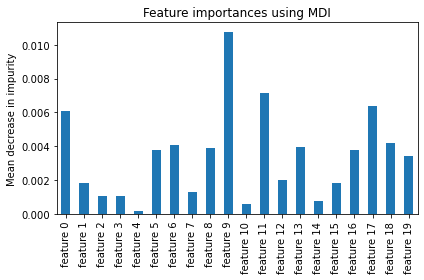

In [166]:
importances = rfc.feature_importances_[:20]
feature_names = [f"feature {i}" for i in range(X_train_processed.shape[1])][:20]
forest_importances = pd.Series(importances, index=feature_names)[:20]
#std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [604]:
# need to do this in command line
# brew install libomp 
# https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded
import neptune.new as neptune
 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#import lightgbm

MODEL_PARAMS = {'random_state': 42,
                'learning_rate': 0.1,
                'n_estimators': 200, 
                'scale_pos_weight': 100}

# Train model
model = lightgbm.LGBMClassifier(**MODEL_PARAMS)
model.fit(X_train_processed, y_train)

# Evaluate model
y_test_pred = model.predict_proba(X_test_processed)
y_train_pred = model.predict_proba(X_train_processed)

print_scores(y_train, y_train_pred, y_test, y_test_pred)

ERROR: Could not find a version that satisfies the requirement neptune (from versions: none)
ERROR: No matching distribution found for neptune
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'neptune'

In [1144]:
pipe = Pipeline(steps=[
    ("lr", LogisticRegression(random_state=42, class_weight=)),
    #("dt", DecisionTreeClassifier(random_state=42))
])

# Use the pipeline to fit the model and score it
pipe.fit(X_train_processed, y_train)
pipe.score(X_test_processed, y_test)

AttributeError: 'Pipeline' object has no attribute 'recall_score'

In [735]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

X_10_best= SelectKBest(f_classif, k=10).fit(X_train_processed, y_train)
mask = X_10_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train_processed.columns):
    if bool:
        new_feat.append(feature)
print('The best features (using f_classif score) are: {}'.format(new_feat)) 
# The list of 10 best features

ValueError: Found input variables with inconsistent numbers of samples: [25530, 23992]

In [308]:
## long runtime

from sklearn.feature_selection import RFE
estimator = logreg3
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train_scaled, y_train)
rfe_mask = selector.get_support() #list of booleans for selected features

new_features = [] 
for bool, feature in zip(rfe_mask, X_train_scaled.columns):
    if bool:
        new_features.append(feature)

new_features # The list of your 5 best features

KeyboardInterrupt: 